<a href="https://colab.research.google.com/github/UrienLin/NLPTest/blob/master/Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information Retrieval


# 新聞「立場」檢索
> [根據本篇論文](https://www.aclweb.org/anthology/D19-3004.pdf)

## **前處理** > 篩選出較相關 TopK 句子

### 1.透過標點符號斷句<br>

### 2.篩選出 相關性最高 TOP5的句子<br>
> update:時間因素，改採Jieba TF_IDF TOP 5 有出現的句子<br>

> Note:Relevant 跟 (Both Query & News 的 TF_IDF 詞交集)不明顯相關<br>

### 3.標題作為Text_a ,篩選後句子合併為Text_b, label=Relevance

## **模型訓練** > BERT 訓練 Query 跟 篩選句的相關

### 1. BertForSequenceClassification
> Format = [CLS] Query [SEP] 篩選句[SEP] <br>
> Masked = [CLS] 00000 [SEP] 11111 [SEP]


In [1]:
!pip install jieba -q
!pip install transformers -q
from google.colab import drive
drive.mount('/content/drive')

import pandas as  pd
import jieba.analyse

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Colab PATH
#PATH = '/content/drive/My Drive/20190825 Challenge/'
#Local PATH
PATH = './'

train_df = pd.read_csv(PATH + '02_Newstrain.csv')
test_df = pd.read_csv(PATH + '02_Newstest.csv')
_df = pd.concat([train_df,test_df])
_df.head()


,query,news,relevance
0,支持陳前總統保外就醫,前總統陳水扁律師團今天說，法務部若依醫療鑑定小組認定，准扁保外就醫，重視醫療人權，在國際能見...,2.0
1,支持陳前總統保外就醫,2014.12.05，大家晚安！每天晚間為您彙整夜線最讚新聞，一起來看看今天的夜線最讚新聞有...,1.0
2,支持陳前總統保外就醫,針對法務部昨（8）日指若前總統陳水扁近半年病情確有變化，可再次提出保外就醫聲請，民主進步黨發...,3.0
3,支持陳前總統保外就醫,前總統陳水扁申請重回民進黨，因爭議過大，受理的台北市黨部昨日以「逕送中央」方式，表達拒審態度...,1.0
4,支持陳前總統保外就醫,高雄市政府今天舉行升旗典禮，市長陳菊呼籲，法務部矯正署盡速完成應做的行政程序，讓前總統陳水扁...,3.0


In [3]:
_df['extract'] = _df.news.apply(lambda x: jieba.analyse.extract_tags(x,topK=10))
_df['top5']= _df.extract.apply(lambda x: x[:5])

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.641 seconds.
Prefix dict has been built successfully.


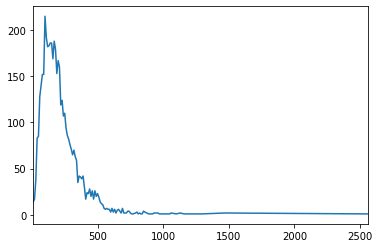

In [4]:
def extract_list_contains(cell):
   list_sentence = []
   for sub_str in cell[-5]:
    list_sentence += [x for x in cell[:-5] if sub_str in x ]
   return list(set(list_sentence))

_df.news = _df.news.apply(lambda x:x.replace(",", "，"))
_df.news = _df.news.apply(lambda x:x.replace("。", "，"))
_df.news = _df.news.apply(lambda x:x.replace("？", "，"))
_df.news = _df.news.apply(lambda x:x.replace("；", "，"))
_df.news = _df.news.apply(lambda x:x.replace("、", "，"))
_df.news = _df.news.apply(lambda x:x.replace("！", "，"))

_df['sentences'] = _df.news.apply(lambda x:x.split('，'))
_df['filter_raw'] = _df.sentences + _df.top5

_df['test'] = _df.filter_raw.apply(extract_list_contains)
_df['filter_text'] = _df.test.apply(lambda x:','.join(x))
_df.filter_text.str.len().map(lambda x:int(x/10)*10).value_counts().sort_index().plot()

In [5]:
_df[_df.filter_text.str.len()>300].head()

,query,news,relevance,extract,top5,sentences,filter_raw,test,filter_text
3,支持陳前總統保外就醫,前總統陳水扁申請重回民進黨，因爭議過大，受理的台北市黨部昨日以「逕送中央」方式，表達拒審態度...,1.0,"[入黨, 民進, 中央, 申請, 還是, 扁入, 進行, 程序, 台北市, 總統]","[入黨, 民進, 中央, 申請, 還是]","[前總統陳水扁申請重回民進黨, 因爭議過大, 受理的台北市黨部昨日以「逕送中央」方式, 表達...","[前總統陳水扁申請重回民進黨, 因爭議過大, 受理的台北市黨部昨日以「逕送中央」方式, 表達...","[日前民進黨調查黑道入黨爭議時, 昨日上午先由主委莊瑞雄發函黨中央, 地方黨部實在無法說「y...","日前民進黨調查黑道入黨爭議時,昨日上午先由主委莊瑞雄發函黨中央,地方黨部實在無法說「yeso..."
31,支持陳前總統保外就醫,串聯綠委優先搶救扁命〔記者李欣芳／台北報導〕台灣客社社長張葉森等本土社團幹部連日來串聯二十位...,3.0,"[阿扁, 立委, 連署, 張葉森, 水扁, 其邁, 醫療, 健康, 優先, 社團]","[阿扁, 立委, 連署, 張葉森, 水扁]",[串聯綠委優先搶救扁命〔記者李欣芳／台北報導〕台灣客社社長張葉森等本土社團幹部連日來串聯二十...,[串聯綠委優先搶救扁命〔記者李欣芳／台北報導〕台灣客社社長張葉森等本土社團幹部連日來串聯二十...,"[他關切陳水扁的醫療與司法人權, 爭取讓阿扁保外就醫或移監到高雄, 但當前應優先搶救阿扁, ...","他關切陳水扁的醫療與司法人權,爭取讓阿扁保外就醫或移監到高雄,但當前應優先搶救阿扁,目前應優..."
43,支持陳前總統保外就醫,高分貝護子諷馬觀感不好〔記者施曉光／台北報導〕台北市長郝龍斌日前砲轟國民黨中央，點名要求如果...,1.0,"[郝龍斌, 郝柏村, 國民黨, 兒子, 觀感, 意見, 英九, 談話, 主席, 大家]","[郝龍斌, 郝柏村, 國民黨, 兒子, 觀感]","[高分貝護子諷馬觀感不好〔記者施曉光／台北報導〕台北市長郝龍斌日前砲轟國民黨中央, 點名要求...","[高分貝護子諷馬觀感不好〔記者施曉光／台北報導〕台北市長郝龍斌日前砲轟國民黨中央, 點名要求...","[高分貝護子諷馬觀感不好〔記者施曉光／台北報導〕台北市長郝龍斌日前砲轟國民黨中央, 痛批郝是...","高分貝護子諷馬觀感不好〔記者施曉光／台北報導〕台北市長郝龍斌日前砲轟國民黨中央,痛批郝是失敗..."
45,支持陳前總統保外就醫,監察院昨通過前總統陳水扁醫療調查報告案，直指法務部有怠失，且醫生認定陳水扁不適合再回監獄，書...,2.0,"[水扁, 醫療, 調查, 報告, 阿扁, 報告案, 法務部, 認定, 監獄, 保外]","[水扁, 醫療, 調查, 報告, 阿扁]","[監察院昨通過前總統陳水扁醫療調查報告案, 直指法務部有怠失, 且醫生認定陳水扁不適合再回監...","[監察院昨通過前總統陳水扁醫療調查報告案, 直指法務部有怠失, 且醫生認定陳水扁不適合再回監...","[台北榮總對陳水扁所做的出院準備報告建議, 監察院昨通過前總統陳水扁醫療調查報告案, 並召集...","台北榮總對陳水扁所做的出院準備報告建議,監察院昨通過前總統陳水扁醫療調查報告案,並召集阿扁民..."
46,支持陳前總統保外就醫,如果，選舉是民主國家權力的正當性基礎，那麼，在九合一潰敗後的國民黨，可說是處在權力正當性的廢...,3.0,"[總統, 判斷, 水扁, 保外, 專業, 醫治, 問題, 政治, 法務部, 權力]","[總統, 判斷, 水扁, 保外, 專業]","[如果, 選舉是民主國家權力的正當性基礎, 那麼, 在九合一潰敗後的國民黨, 可說是處在權力...","[如果, 選舉是民主國家權力的正當性基礎, 那麼, 在九合一潰敗後的國民黨, 可說是處在權力...","[馬總統也就難以迴避, 我們知道馬總統想要尊重專業, 我們期望馬總統與法務部作出政治判斷, ...","馬總統也就難以迴避,我們知道馬總統想要尊重專業,我們期望馬總統與法務部作出政治判斷,馬總統依..."


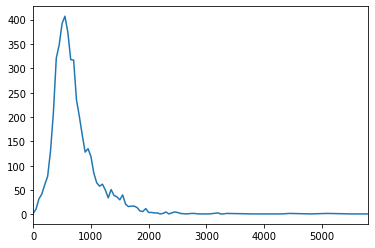

In [6]:
_df.news.str.len().map(lambda x: int(x/50)*50).value_counts().sort_index().plot()

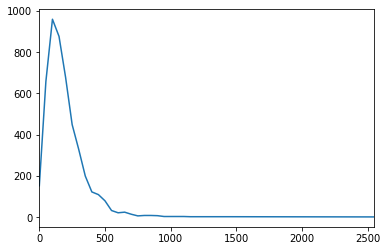

In [7]:
_df.filter_text.str.len().map(lambda x: int(x/50)*50).value_counts().sort_index().plot()

#透過斷句及篩選       <br>大概將文本字數刪減至一半 <br >以利Bert分析

In [0]:
def get_split(text1):
  text_total_len = 200 #default:200
  text_overlap = 50 #default:50
  text_len = text_total_len - text_overlap
  
  l_total = []
  l_parcial = []
  if len(list(text1))//text_len >0:
    n = len(list(text1))//text_len
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = list(text1)[:text_total_len]
      l_total.append("".join(l_parcial))
    else:
      l_parcial = list(text1)[w*text_len:w*text_len + text_total_len]
      l_total.append("".join(l_parcial))
  return l_total
_df['filter_split'] = _df.filter_text.apply(get_split)

In [9]:
text_a = []
text_b = []
label_l = []
index_l = []

for idx,row in _df.iterrows():
  for rs in row['filter_split']:
    text_a.append(row['query'])
    text_b.append(rs)
    label_l.append(row['relevance'])
    index_l.append(idx)

len(text_a), len(text_b),len(label_l),len(index_l)

(6254, 6254, 6254, 6254)

In [10]:
new_df = pd.DataFrame({'text_a':text_a, 'text_b':text_b, 'label':label_l, 'idx':index_l})
new_df.head()

,text_a,text_b,label,idx
0,支持陳前總統保外就醫,"早就應該儘快「保外就醫」,鑑定結果一致認定通過「阿扁應保外就醫,准扁保外就醫,外界關切陳水扁...",2.0,0
1,支持陳前總統保外就醫,"鎖定中時,中時電子報提供您最新生活資訊,她在學校上電腦課時,(中時電子報),同時表態自己是支...",1.0,1
2,支持陳前總統保外就醫,"陳水扁的健康狀況過去兩年來包括台北榮總,針對法務部昨（8）日指若前總統陳水扁近半年病情確有變...",3.0,2
3,支持陳前總統保外就醫,"日前民進黨調查黑道入黨爭議時,昨日上午先由主委莊瑞雄發函黨中央,地方黨部實在無法說「yeso...",1.0,3
4,支持陳前總統保外就醫,"入黨複審小組召開會議進行討論,但扁入黨仍是一波三折,旋即由黨秘書長林錫耀邀集組織部主任李文忠...",1.0,3


In [0]:
dev_0225_q2 = new_df[new_df.label!=0.5].sample(1000)
train_raw = pd.concat([new_df,dev_0225_q2]).drop_duplicates(keep=False)
test_0225_q2 = train_raw[train_raw.label == 0.5]
train_0225_q2 = pd.concat([test_0225_q2,train_raw]).drop_duplicates(keep=False)

In [0]:
dev_0225_q2.to_csv(PATH + 'dev_0225_q2.tsv', index=False, sep='\t', encoding='utf-8')
train_0225_q2.to_csv(PATH + 'train_0225_q2.tsv', index=False, sep='\t', encoding='utf-8')
test_0225_q2.to_csv(PATH + 'test_0225_q2.tsv', index=False, sep='\t', encoding='utf-8')

In [13]:

import torch
from torch.utils.data import Dataset

from transformers import BertTokenizer,BertForSequenceClassification
from IPython.display import clear_output

PRETRAINED_MODEL_NAME = "bert-base-chinese"  


tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
    
class NewsDataset(Dataset):

    def __init__(self, mode, tokenizer):
        assert mode in ["train_0225_q2", "test_0225_q2","dev_0225_q2"]  
        self.mode = mode
        self.df = pd.read_csv(PATH + mode + ".tsv", sep="\t").fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  
    
    
    def __getitem__(self, idx):
        if self.mode == "test_0225_q2":
            text_a, text_b = self.df.iloc[idx, :2].values
            label_tensor = None
        else:
            text_a, text_b, label = self.df.iloc[idx, :3].values
           
            label_tensor = torch.tensor(label,dtype=torch.long)
            
      
        word_pieces = ["[CLS]"]
        tokens_a = self.tokenizer.tokenize(text_a)
        word_pieces += tokens_a + ["[SEP]"]
        len_a = len(word_pieces)
        
        tokens_b = self.tokenizer.tokenize(text_b)
        word_pieces += tokens_b + ["[SEP]"]
        len_b = len(word_pieces) - len_a
        
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        segments_tensor = torch.tensor([0] * len_a + [1] * len_b, 
                                        dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
    
# 初始化一個專門讀取訓練樣本的 Dataset，使用中文 BERT 斷詞
trainset = NewsDataset("train_0225_q2", tokenizer=tokenizer)

In [14]:
sample_idx = 0
text_a, text_b, label = trainset.df.iloc[sample_idx, :3].values
tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = "".join(tokens)

print(f"""
句子 1：{text_a}
句子 2：{text_b}
分類  ：{label}
""")



句子 1：支持陳前總統保外就醫
句子 2：早就應該儘快「保外就醫」,鑑定結果一致認定通過「阿扁應保外就醫,准扁保外就醫,外界關切陳水扁能否獲准保外就醫,而准予保外就醫,而有必要保外就醫的人
分類  ：2.0



In [0]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    tokens_tensors = pad_sequence(tokens_tensors, 
                                  batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, 
                                    batch_first=True)
    
    masks_tensors = torch.zeros(tokens_tensors.shape, 
                                dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(
        tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids

BATCH_SIZE = 32
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, 
                         collate_fn=create_mini_batch)

In [16]:
from transformers import BertForSequenceClassification

PRETRAINED_MODEL_NAME = "bert-base-chinese"
NUM_LABELS = 4

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

print("""
name            module
----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))


name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=768, out_features=4, bias=True)


In [17]:

def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
      
    with torch.no_grad():
        for data in dataloader:
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)
            
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)
            
            if compute_acc:
                labels = data[3]
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
    
    if compute_acc:
        acc = correct / total
        return predictions, acc
    return predictions
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)
_, acc = get_predictions(model, trainloader, compute_acc=True)
print("classification acc:", acc)

device: cuda:0
classification acc: 0.29983342587451417


In [0]:
%%time

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


EPOCHS = 7  
for epoch in range(EPOCHS):
    running_loss = 0.0
    for data in trainloader:
        
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data]

        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs[0]
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    _, acc = get_predictions(model, trainloader, compute_acc=True)

    print('[epoch %d] loss: %.3f, acc: %.3f' %
          (epoch + 1, running_loss, acc))
    

In [0]:
%%time
testset = NewsDataset("dev_0225_q2", tokenizer=tokenizer)
testloader = DataLoader(testset, batch_size=64, 
                        collate_fn=create_mini_batch)

predictions = get_predictions(model, testloader)

df = pd.DataFrame({"predicted": predictions.tolist()})
df1 = pd.concat([testset.df, df.loc[:, 'predicted']], axis=1)

In [0]:
df1.head()

In [0]:
%%time
testset2 = NewsDataset("test_0225_q2", tokenizer=tokenizer)
testloader2 = DataLoader(testset2, batch_size=64, 
                        collate_fn=create_mini_batch)

predictions2 = get_predictions(model, testloader2)

df2 = pd.DataFrame({"predicted": predictions2.tolist()})
df1_2 = pd.concat([testset2.df, df2.loc[:, 'predicted']], axis=1)


In [0]:
import numpy as np
#取眾數、高
idx_df = df1_2.groupby('idx').agg(lambda x: int(np.mean(pd.Series.mode(x)))).reset_index()

In [0]:
idx_df

In [0]:
test_df['predicted'] = idx_df.predicted

In [0]:
test_df.to_csv('/content/drive/My Drive/Q2/prediction0226Final.tsv',sep='\t', encoding='utf-8')